# Sampling from QUBO with OMMX Adapter

Here, we explain how to convert a problem to QUBO and perform sampling using the Traveling Salesman Problem as an example.

```{figure} ./assets/taraimawashi_businessman.png
[Illustration of a man in a suit](https://www.irasutoya.com/2017/03/blog-post_739.html)
```

The Traveling Salesman Problem (TSP) is about finding a route for a salesman to visit multiple cities in sequence. Given the travel costs between cities, we seek to find the path that minimizes the total cost. Let's consider the following city arrangement:

In [1]:
# From ulysses16.tsp in TSPLIB
ulysses16_points = [
    (38.24, 20.42),
    (39.57, 26.15),
    (40.56, 25.32),
    (36.26, 23.12),
    (33.48, 10.54),
    (37.56, 12.19),
    (38.42, 13.11),
    (37.52, 20.44),
    (41.23, 9.10),
    (41.17, 13.05),
    (36.08, -5.21),
    (38.47, 15.13),
    (38.15, 15.35),
    (37.51, 15.17),
    (35.49, 14.32),
    (39.36, 19.56),
]

Let's plot the locations of the cities.

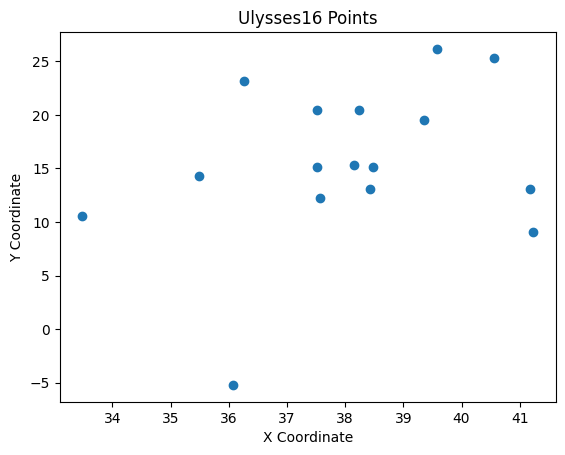

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

x_coords, y_coords = zip(*ulysses16_points)
plt.scatter(x_coords, y_coords)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Ulysses16 Points')
plt.show()

Let's consider distance as the cost. We'll calculate the distance $d(i, j)$ between city $i$ and city $j$.

In [3]:
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Number of cities
N = len(ulysses16_points)
# Distance between each pair of cities
d = [[distance(ulysses16_points[i], ulysses16_points[j]) for i in range(N)] for j in range(N)]

Using this, we can formulate TSP as follows. First, let's represent whether we are at city $i$ at time $t$ with a binary variable $x_{t, i}$. Then, we seek $x_{t, i}$ that satisfies the following constraints. The distance traveled by the salesman is given by:

$$
\sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j}
$$

However, $x_{t, i}$ cannot be chosen freely and must satisfy two constraints: at each time $t$, the salesman can only be in one city, and each city must be visited exactly once:

$$
\sum_{i=0}^{N-1} x_{t, i} = 1, \quad \sum_{t=0}^{N-1} x_{t, i} = 1
$$

Combining these, TSP can be formulated as a constrained optimization problem:

$$
\begin{align*}
\min \quad & \sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j} \\
\text{s.t.} \quad & \sum_{i=0}^{N-1} x_{t, i} = 1 \quad (\forall t = 0, \ldots, N-1) \\
\quad & \sum_{t=0}^{N-1} x_{t, i} = 1 \quad (\forall i = 0, \ldots, N-1)
\end{align*}
$$

The corresponding `ommx.v1.Instance` can be created as follows:

In [4]:
from ommx.v1 import DecisionVariable, Instance

x = [[
        DecisionVariable.binary(
            i + N * t,  # Decision variable ID
            name="x",           # Name of the decision variable, used when extracting solutions
            subscripts=[t, i])  # Subscripts of the decision variable, used when extracting solutions
        for i in range(N)
    ]
    for t in range(N)
]

objective = sum(
    d[i][j] * x[t][i] * x[(t+1) % N][j]
    for i in range(N)
    for j in range(N)
    for t in range(N)
)
place_constraint = [
    (sum(x[t][i] for i in range(N)) == 1)
        .set_id(t)  # type: ignore
        .add_name("place")
        .add_subscripts([t])
    for t in range(N)
]
time_constraint = [
    (sum(x[t][i] for t in range(N)) == 1)
        .set_id(i + N)  # type: ignore
        .add_name("time")
        .add_subscripts([i])
    for i in range(N)
]

instance = Instance.from_components(
    decision_variables=[x[t][i] for i in range(N) for t in range(N)],
    objective=objective,
    constraints=place_constraint + time_constraint,
    sense=Instance.MINIMIZE
)

The variable names and subscripts added to `DecisionVariable.binary` during creation will be used later when interpreting the obtained samples.


## Sampling with OpenJij

To sample the QUBO described by `ommx.v1.Instance` using OpenJij, use the `ommx-openjij-adapter`.

In [5]:
from ommx_openjij_adapter import OMMXOpenJijSAAdapter

sample_set = OMMXOpenJijSAAdapter.sample(instance, num_reads=16, uniform_penalty_weight=20.0)
sample_set.summary

,objective,feasible
sample_id,,
6,89.025665,True
13,93.744889,True
0,94.078199,True
4,99.965104,True
14,109.207744,True
2,109.912396,True
1,113.898447,True
5,94.625957,False
3,96.923372,False


[`OMMXOpenJijSAAdapter.sample`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx_openjij_adapter/index.html#ommx_openjij_adapter.OMMXOpenJijSAAdapter.sample) returns [`ommx.v1.SampleSet`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.SampleSet), which stores the evaluated objective function values and constraint violations in addition to the decision variable values of samples. The `SampleSet.summary` property is used to display summary information. `feasible` indicates the feasibility to **the original problem** before conversion to QUBO. This is calculated using the information stored in `removed_constraints` of the `qubo` instance.

To view the feasibility for each constraint, use the `summary_with_constraints` property.

In [6]:
sample_set.summary_with_constraints

,objective,feasible,place[0],place[1],place[2],place[3],place[4],place[5],place[6],place[7],...,time[6],time[7],time[8],time[9],time[10],time[11],time[12],time[13],time[14],time[15]
sample_id,,,,,,,,,,,,,,,,,,,,,
6,89.025665,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
13,93.744889,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0,94.078199,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,99.965104,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
14,109.207744,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,109.912396,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,113.898447,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,94.625957,False,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True
3,96.923372,False,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True


For more detailed information, you can use the `SampleSet.decision_variables` and `SampleSet.constraints` properties.

In [7]:
sample_set.decision_variables_df.head(2)

,kind,lower,upper,name,subscripts,description,0,1,2,3,...,6,7,8,9,10,11,12,13,14,15
id,,,,,,,,,,,,,,,,,,,,,
0,Binary,-0.0,1.0,x,"[0, 0]",None,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Binary,-0.0,1.0,x,"[0, 1]",None,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
sample_set.constraints_df.head(2)

,equality,used_ids,name,subscripts,description,removed_reason,value.0,value.1,value.2,value.3,...,feasible.6,feasible.7,feasible.8,feasible.9,feasible.10,feasible.11,feasible.12,feasible.13,feasible.14,feasible.15
id,,,,,,,,,,,,,,,,,,,,,
0,=0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",place,[0],None,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
1,=0,"{16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",place,[1],None,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True


To obtain the samples, use the `SampleSet.extract_decision_variables` method. This interprets the samples using the `name` and `subscripts` registered when creating `ommx.v1.DecisionVariables`. For example, to get the value of the decision variable named `x` with `sample_id=1`, use the following to obtain it in the form of `dict[subscripts, value]`.

In [9]:
sample_id = 1
x = sample_set.extract_decision_variables("x", sample_id)
t = 2
i = 3
x[(t, i)]

0.0

Since we obtained a sample for $x_{t, i}$, we convert this into a TSP path. This depends on the formulation used, so you need to write the processing yourself.

In [10]:
def sample_to_path(sample: dict[tuple[int, ...], float]) -> list[int]:
    path = []
    for t in range(N):
        for i in range(N):
            if sample[(t, i)] == 1:
                path.append(i)
    return path

Let's display this. First, we obtain the IDs of samples that are feasible for the original problem.

In [11]:
feasible_ids = sample_set.summary.query("feasible == True").index
feasible_ids

Index([6, 13, 0, 4, 14, 2, 1], dtype='int64', name='sample_id')

Let's display the optimized paths for these samples.

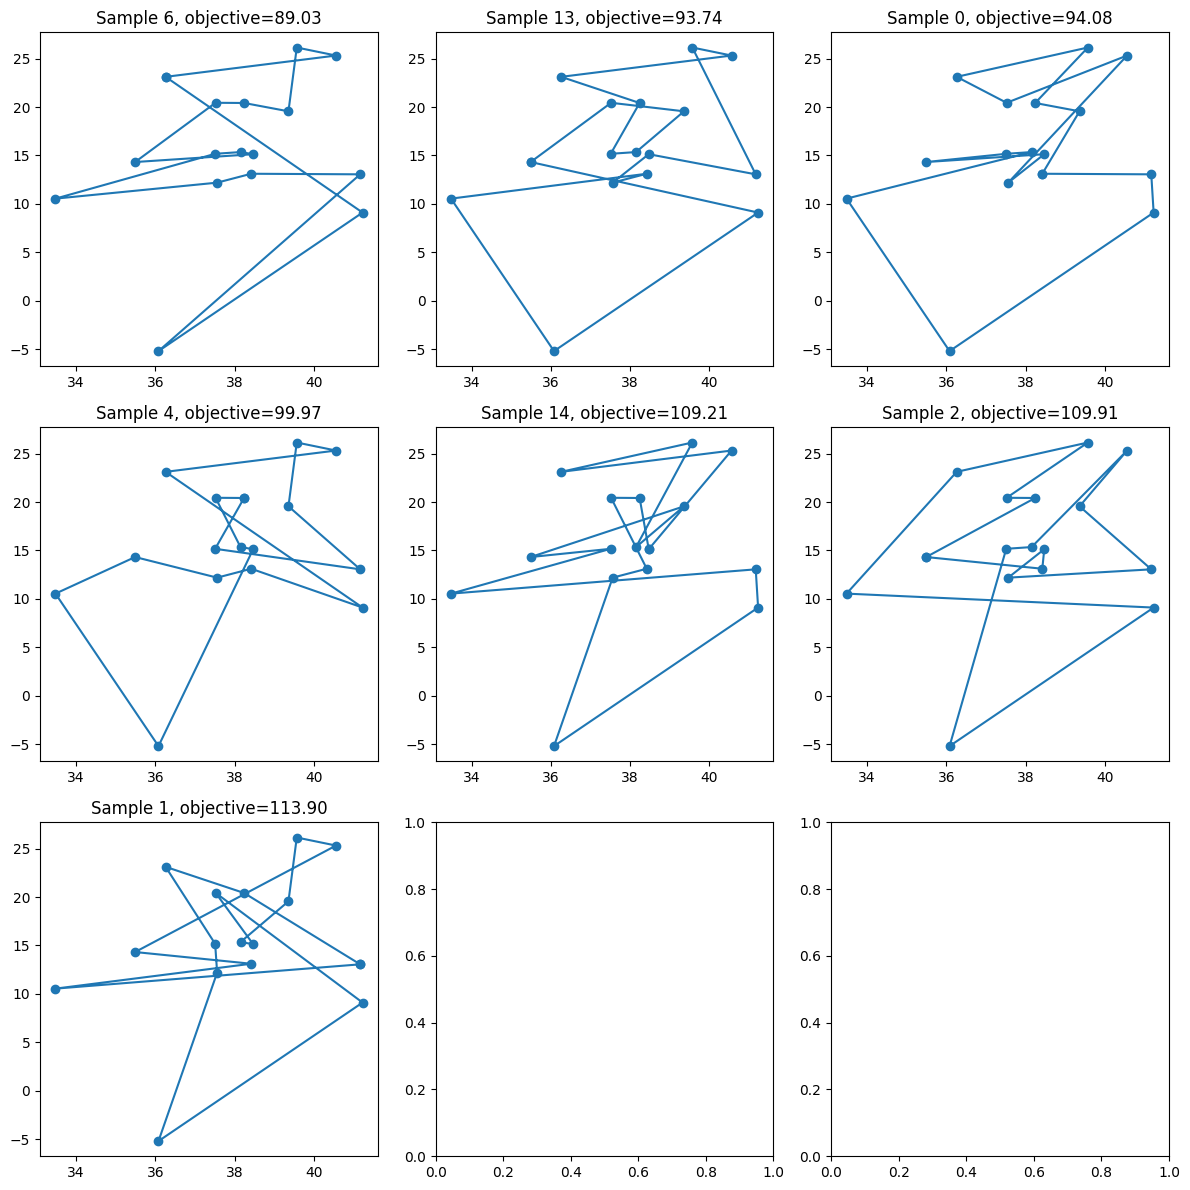

In [12]:
fig, axie = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axie.flatten()):
    if i >= len(feasible_ids):
        break
    s = feasible_ids[i]
    x = sample_set.extract_decision_variables("x", s)
    path = sample_to_path(x)
    xs = [ulysses16_points[i][0] for i in path] + [ulysses16_points[path[0]][0]]
    ys = [ulysses16_points[i][1] for i in path] + [ulysses16_points[path[0]][1]]
    ax.plot(xs, ys, marker='o')
    ax.set_title(f"Sample {s}, objective={sample_set.objectives[s]:.2f}")

plt.tight_layout()
plt.show()